# Tour

A **quick tour** of the topics in these notes. You can just look at the output below.  If you want to **run the code**, see the next section.  This tour discusses the following topics:

- How to run the code
- Key difference between AI and Classical Programming
- Linear Regressions
- Stochastic Gradient Descent
- Neural Network Regressions

## To run the code

Click on the **rocket** symbol on the top of the page and select **Live Code**. It will take
a little while to launch and then you will see **ready**. The code runs on an external server, so you don't have to install any software. It is important to **run the code cells** sequentially without skipping, as values computed in one cell are reused in later cells. If something goes wrong, restart from the first cell. Some cells **take a long time** to run.  Please wait until they are done before moving on. The cells with widgets to select parameters are a bit kludgy to go around some bugs in the current version of Jypyter Book.  


## AI vs Classical Programming

Here is a little picture that illustrates the difference between **classical programming** and **AI**.

![title](Figures/AIvsClassical.pdf)

We illustrates this difference on a concrete example.  We have a list, called **data** (as in Data Science), ${\cal D} = (X_n, Y_n), n = 1, \ldots, N\}$ of pairs of real numbers. Say that $X_n$ is the height and $Y_n$ the weight of person $n$.  We want to use this data to learn to predict the weight $Y$ of an arbitrary person from his/her height $X$.  

* In **classical programming**, we have rules that tell us how to compute $X$. One such rule is **linear regression**; it computes two coefficients $a$ and $b$ from ${\cal D}$ and then specifies that the estimation is $Y = aX + b$. In other words, we know how to compute $a$ and $b$ from the input ${\cal D}$. This is the the top part of the figure above.  

* In **AI**, we build a **system** (a machine learning algorithm) that *looks for the rules* by trying an estimator and refinining it using ${\cal D}.$ As an example, the system starts with an estimator $X = a_0 + b_0 X$. The system has an *improvement process* that tells it how to update $(a_0, b_0)$.  A typical approach is **stochastic gradient descent** (SGD) that modifies $(a_0, b_0)$ in the direction that reduces $(a + bX_1 - Y_1)^2$ and produces $(a_1, b_1)$.  In the next step, the system modifies $(a_1, b_1)$ in the direction that reduces $(a + bX_2 - Y_2)^2$ and produces $(a_2, b_2)$, and so on. The idea is that the updates should reduce the average value of $(a + bX - Y)^2$.
This is the bottom part of the figure above. This approach is at the core of most AI algorithms.

## Let's try these two approaches

### First we use the linear regression.

We use pandas to explore sample data.  (The Appendix has a brief discussion of Pandas. It is a bridge between spreadsheets and Python.) We use a table of weights and heights borrowed from

http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights

This data is in the excel spreadsheet HW.xlsx.  First, we read the spreadsheet into a DataFrame. 
We then calculate the linear regression of weight over height. (More about this in later chapters.)
We then plot.  We label the data **train $X, Y$** because we use it to do the regression.

In [43]:
# First, we import some libraries

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
params = {'figure.figsize':(12,6), # These are plot parameters
         'xtick.labelsize': 16,
         'ytick.labelsize':16,
         'axes.titlesize':18,
         'axes.labelsize':18,
         'lines.markersize':4,
         'legend.fontsize': 20}
matplotlib.rcParams.update(params)
import scipy
import pandas as pd
import openpyxl
import random
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display, HTML

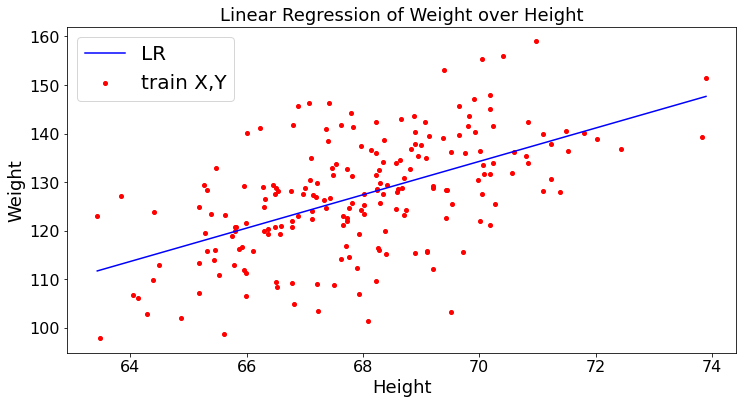

In [32]:


import pandas as pd
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import load_workbook
wb = load_workbook('./HW.xlsx')  

from sklearn.linear_model import LinearRegression
def fitLR(X,Y): # here X and Y are two lists
    linear_regressor = LinearRegression()  # create object for the class
    Xcol = np.array(X).reshape((-1, 1)) # convert X into a column - needed by regressor
    linear_regressor.fit(Xcol, Y)  # perform linear regression
    B = linear_regressor.coef_
    A = linear_regressor.intercept_ # the linear regression is A + Bx 
    return A, B

def plotFitLR(X,Y,A, B):
    xaxis = [min(X) + 0.01*n*(max(X) - min(X)) for n in range(101)]
    plt.scatter(X,Y,label ='train X,Y',color='r')
    y = [A + B*x for x in xaxis]
    plt.plot(xaxis,y,color='b',label='LR')
    plt.ylabel('Weight')
    plt.xlabel('Height')
    plt.legend()


HW_df = pd.read_excel('./HW.xlsx',index_col = 0)
X = list(HW_df.iloc[:,0])
Y = list(HW_df.iloc[:,1])
M = len(X)
A, B = fitLR(X,Y)
plotFitLR(X,Y,A, B)
plt.title("Linear Regression of Weight over Height")
plt.show()



### Next, we use SGD

Instead of using the formula for linear regression, we use SGD to improve a predictor $Y = a + bX$.  We do this by modifying $a$ in the direction of the derivative of $- (a + bX_m - Y_m)^2$ with respect to $a$. We also modify $b$ in the direction of the derivative of $- (a + bX_m - Y_m)^2$ with respect to $b$. Here, $(X_m, Y_m)$ is a pair picked randomly from the list of pairs, with replacement.  The goal is to minimize the squared error $(a + bX - Y)^2$.  Thus, we change $a$ and $b$ in the direction of decrease of that expression, when evaluated on samples.  On average, this should decrease the squared error.

In the example below, you will note that one only has $200$ items in the data, 
but one performs tens of thousands of iterations
by repeatedly resampling from the data. This trick is called **bootstrap**. It amounts to considering that
our samples are representative of a vast population.  As you can see from the example, **choosing the step sizes** is tricky: tradeoff between speed of convergence and accuracy.

Note a clear benefit of this approach: you don't need to understand anything about statistics!

In [33]:
dAd = widgets.Dropdown(options=['5', '10', '15','20','25','30','35','40'],value='20',description='dA(-2)',disabled=False)
dBd = widgets.Dropdown(options=['1', '2', '3','4','5','6','7','8','9','10'],value='4',description='dB(-5)',disabled=False)
Nd = widgets.Dropdown(options=['10', '20', '30','40','50','60','70','80','90','100'],value='80',description='N(3)',disabled=False)

In [34]:
def dummy2(dAd,dBd,Nd):
    global dA, dB, N
    dA, dB, N = float(dAd), float(dBd), int(Nd)

z = widgets.interactive(dummy2, dAd = dAd, dBd = dBd, Nd = Nd) 
display(z)

interactive(children=(Dropdown(description='dA(-2)', index=3, options=('5', '10', '15', '20', '25', '30', '35'…

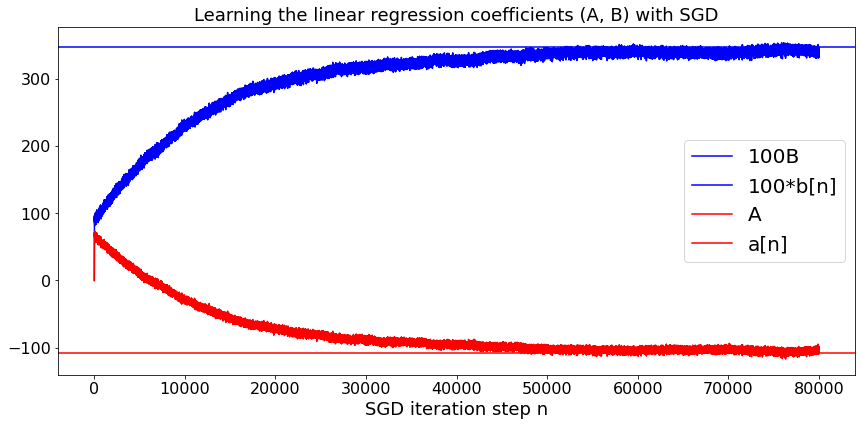

Here, A and B are the coefficients given by the linear regression formulas.
To try different values of the step sizes dA and dB and the number of steps N, go back to previous cell and rerun.
Sorry, this is needed because of a bug in Jupyter Books.


In [49]:
def learnLinR(dA,dB,N):
    
    N = 1000*int(N)
    a = np.zeros(N) # a[n], b[n] are the predictor coefficients after n steps
    b = np.zeros(N)
    dA = float(dA)*10**(-2) # These are the step sizes of the algorithm
    dB = float(dB)*10**(-5) # They are different for a and b
    for n in range(N-1):
        m = random.choice(range(len(X)))
        Xs, Ys = X[m], Y[m] # pick a person randomly from the data
        a[n+1] = a[n] - dA*(a[n] + b[n]*Xs - Ys)
        b[n+1] = b[n] - dB*Xs*(a[n] + b[n]*Xs - Ys)
        
    fig, axes = plt.subplots(nrows=1, ncols=1)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Or equivalently, "plt.tight_layout()"
    plt.title('Learning the linear regression coefficients (A, B) with SGD')
    plt.axhline(y=100*B, color='b', linestyle='-',label='100B')
    plt.plot(100*b,label='100*b[n]',color='b')
    plt.axhline(y=A, color='r', linestyle='-',label='A')
    plt.plot(a,label='a[n]',color='r')
    plt.xlabel('SGD iteration step n')
    plt.legend()
    plt.show()
    


learnLinR(dA,dB,N)

print('Here, A and B are the coefficients given by the linear regression formulas.')
print('To try different values of the step sizes dA and dB and the number of steps N, go back to previous cell and rerun.')
print('Sorry, this is needed because of a bug in Jupyter Books.')



## Train and Test

Fitting the available data is not the real objective.  We want an estimator that works well on data we have not seen. That is, we want an estimator that **generalizes**. For instance, say that all the heights in our data are different. Fitting is then trivial: define a function $f(\cdot)$ by $f(X_n) = Y_n$ for $n = 1, \ldots, N$.  This function fits the available data perfectly.  However, it is not likely to generalize.  Say that one new person shows up with a height $X$ that happens to be exactly $X_n$, for some $n$ in our available data.  What are the odds that the weight $Y$ of that person is equal to $Y_n$?  Very small indeed.  This is an example of **overfitting**.  It is likely that the linear regression $Y = a + bX$ is a better estimator.  By the way, it is possible to **underfit** the available data. An example would be an estimator $f(X) = a$ where $a$ is the average weight in the available data.  This estimator does not capture the dependency of the weight on the height.

How do we know if our estimator generalizes?  The trick is to divide ${\cal D}$ into two subsets: a **training set** ${\cal T}$ and a **testing set** ${\cal D} \setminus {\cal T}$.  We use only ${\cal T}$ to learn $(a, b)$.  We then try the predictor $a + bX$ on ${\cal D} \setminus {\cal T}$.  Let's do this for the linear regression. We select $80\%$ of the samples randomly in ${\cal D}$ to define ${\cal T}$.  We then compute the linear regression based on ${\cal T}$. Finally, we compute the average squared error on ${\cal D} \setminus {\cal T}$.

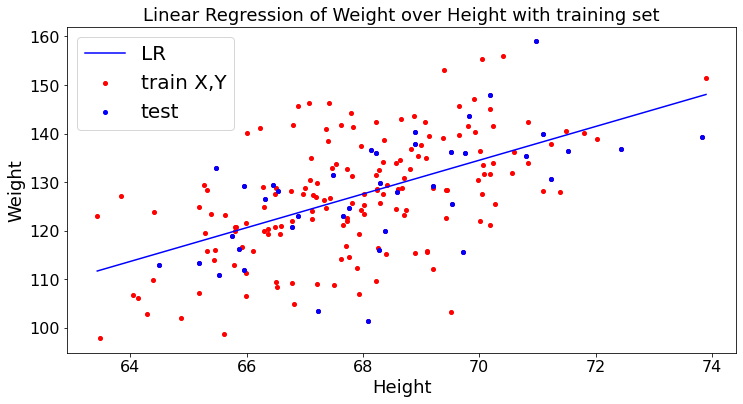

rectified mse/average (%): train =  7.9 ; test =  7.4


In [36]:
from random import sample
number_samples = round(0.8*M)
Train = random.sample(range(M),number_samples) # random subset of range(M), no repetitions
Test = list(set(range(M)).difference(set(Train)))
Xtrain = [X[n] for n in Train] 
Ytrain = [Y[n] for n in Train]
Xtest = [X[n] for n in Test]
Ytest = [Y[n] for n in Test]
A, B = fitLR(Xtrain,Ytrain)
plotFitLR(X,Y,A, B)
plt.title("Linear Regression of Weight over Height with training set")
plt.scatter(Xtest, Ytest,color='b',label='test')
plt.legend()
plt.show()

def cvar(listX, listY, A, B):
    x = 0
    for n in range(len(listX)):
        x += (listY[n] - A - B*listX[n])**2
    x = x/len(listX)
    y = (x**(0.5))/abs(np.average(listY))
    return round(100*y[0],1)
    
cvarTrain = cvar(Xtrain, Ytrain, A, B)
cvarTest = cvar(Xtest, Ytest, A, B)
print('rectified mse/average (%): train = ', cvarTrain,'; test = ', cvarTest)


## Regression with a Neural Network

The main idea in the example above is that one has a predictor $Y = f(\theta, X)$ where $\theta$
is a vector of parameters.  We chose $f(\theta, X) = a + bX$, so that the parameters were $\theta = (a, b)$.
We then used SGD to learn the parameters:

$$\theta(n+1) = \theta(n) - \delta \nabla (f(\theta, X_n) - Y)^2$$

where $\nabla$ indicates the vector of partial derivatives with respect to the components of $\theta$; also,
$\delta$ is a step size.  (In fact, if you look at the code, we saw that it may be useful to have different step sizes for the different components of $\theta$.)

We could use a different function $f$. The key property that we need is that one should
be able to compute the partial derivatives of $f(\theta, X)$.  Indeed, the product rule of calculus says that

$$\nabla (f(\theta, X_n) - Y)^2 = 2 (f(\theta, X_n) - Y) \nabla f(\theta, X_n).$$

In this section, we use a neural network. As you will see, it is easy to compute $\nabla f(\theta, X_n)$.

Our neural network looks like this:

![title](Figures/NN1.pdf)

This figure simply means that

$$f(a, b, X_n) = \sum_{k =1}^K b_k \max\{X_n - a_k, 0\}.$$

The $b_k$ are called the **output weights** and the $a_k$ the **activation thresholds** of the $K$ **neurons**.
The neurons implement a nonlinear function $\max\{x - a, 0\}$ called a **rectified linear unit** (ReLU).
It is possible to appoximate an arbitrary function with such a network, as the figure below shows:

![title](Figures/NN2.pdf)

If we order the $a_k$ so that $a_1 < a_2 < \cdots < a_K$, then we see that the function is zero for $x < a_1$,
then its slope is $b_1$ from $a_1$ to $a_2$, then $b_1 + b_2$ from $a_2$ to $a_3$, and so on.  Thus, the parameters of the network have a clear meaning.  The $a_k$ are the corner points of the function and the $b_k$ are the increments of the slope. The network is **explainable**.  As we will see later in the notes, this is not the case for more complex networks, which is somewhat worrysome.  


This network is a **black box**. It does not assume anything about the shape of the function one tries to approximate. This flexibility is handy when trying to recognize dogs and cats, but more about that later.  In the code below, we implement the neural network from scratch.  This is instructive and demystifying.  Later, we will use packages that do it for us.


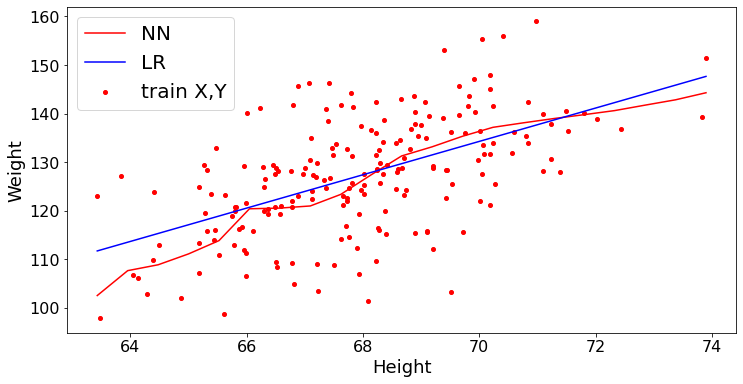

rectified mse/average (%): NN =  8.0 ; LR =  7.8


In [37]:
def fnn(x,a,b): # define the neural network function
    v = 0
    for k in range(len(a)):
        v+= b[k]*max(x - a[k],0)
    return v

def fitNN(X,Y,K,boost,delta):  # K neurons, boot*M resampling, delta = step size   
    M = len(X) # the number of data points
    N = boost*M # the number of iterations with bootstrap
    b = np.zeros([N,K])
    a = np.zeros(K)
    a[0] = min(X) - (max(X) - min(X)) # this allows to choose the value at min(HA)
    for k in range(1,K):  # spread corner points evently  
        a[k] =  min(X) + (k/K)*(max(X) - min(X))
    b[0,:] = np.random.uniform(-1,1,K)# why not?
    for n in range(N-1):
        for k in range(K):
            m = random.choice(range(M)) # bootstrap
            x, y = X[m], Y[m]
            b[n+1,k] = b[n,k] - delta*(fnn(x,a,b[n,:])- y)*max(0,x - a[k])
    # Note that we do not update the a[k] in this algorithm.  We could have        
    return a, b[N-1,:]
 
def plotFitNN(X,Y,a,b):
    xaxis = [min(X) + 0.01*n*(max(X) - min(X)) for n in range(101)]
    y = [fnn(x,a,b) for x in xaxis]
    plt.plot(xaxis,y,color='r',label='NN')
    

    
def cvarNN(X,Y,a,b):
    x = 0
    for n in range(len(X)):
        x += (Y[n] - fnn(X[n],a,b))**2
    x = (x/len(X))**(0.5)
    y = x/abs(np.average(Y))
    return round(100*y,1)
    
    
a, b = fitNN(X,Y,20,100,0.002)
plotFitNN(X,Y,a,b)


A, B = fitLR(X,Y)
plotFitLR(X,Y,A, B)
plt.show()

print('rectified mse/average (%): NN = ', cvarNN(X,Y,a,b),'; LR = ', cvar(X,Y,A,B))


As before, we should test these approaches.  Again, we split the data into a training and a testing set. We fit on the training set and we evaluate the fit on the testing set.

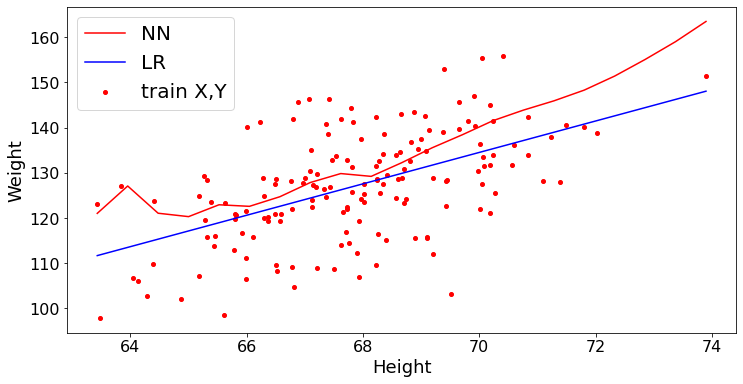

rectified mse/average (%): NN =  8.6 ; LR =  7.4


In [38]:
a, b = fitNN(Xtrain,Ytrain,20,100,0.002)
plotFitNN(Xtrain,Ytrain,a,b)


A, B = fitLR(Xtrain,Ytrain)
plotFitLR(Xtrain,Ytrain,A,B)
plt.show()

print('rectified mse/average (%): NN = ', cvarNN(Xtest,Ytest,a,b),'; LR = ', cvar(Xtest,Ytest,A,B))


## Another Example

In the previous example, a linear estimator is very good. Leet's try another example where that is not the case. This example will show the benefits of using a neural network.  Here, the pairs are $(X_n, Y_n)$ where $X_n$ is uniform in $[-1, 1]$ and $Y_n = g(X_n) + \xi_n$ where $g(\cdot)$ is a piecewise constant function, and $\xi_n$ are Gaussian with mean zero and variance $0.09$ (see Appendix).  Here, a linear regression is not likely to work well.  Let's see if the neural network does better.

In [39]:
Md = widgets.Dropdown(options=['50', '100', '150', '200','250','300','350','400'],value='100',description='M',disabled=False)
Kd = widgets.Dropdown(options=['5', '10', '15','20','25','30'],value='10',description='K',disabled=False)
deltad = widgets.Dropdown(options=['0.005', '0.01', '0.015','0.02','0.025','0.03','0.035','0.04'],value='0.03',description='delta',disabled=False)
boostd = widgets.Dropdown(options=['1', '10', '50','100','150','200','250'],value='100',description='boost',disabled=False)


In [40]:
def dummy(Md,Kd,deltad,boostd):
    global M,K,delta,boost
    M, K, delta, boost = int(Md), int(Kd), float(deltad), int(boostd)
z = widgets.interactive(dummy, Md=Md,Kd=Kd,deltad=deltad,boostd = boostd) 
display(z)

interactive(children=(Dropdown(description='M', index=1, options=('50', '100', '150', '200', '250', '300', '35…

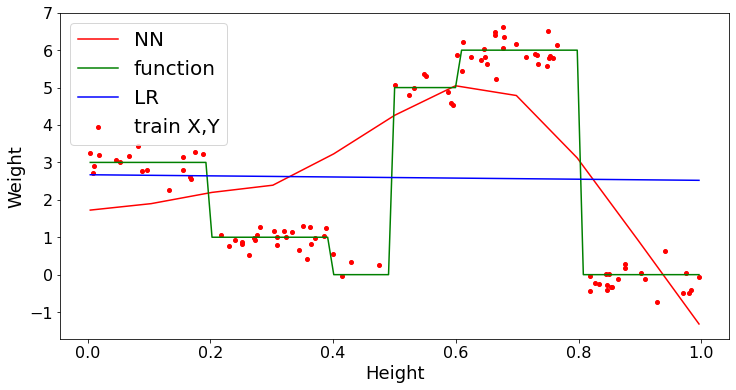

rectified mse/average (%): NN =  61.8 ; LR =  93.5


In [41]:
def funcg(x): # We define the function
    L = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9]
    A = [3,1,0, 5,6,0]
    for i in range(6):
        if L[i] > x:
            return A[i]
    return A[5]

def NNexperiment(M,K,delta,boost):
    # We generate a data set with M samples
    Xs = []
    Ys = []
    stdv = 0.3
    for n in range(M):
        u = np.random.uniform(0, 1)
        v = funcg(u) + np.random.normal(0,stdv)
        Xs.append(u)
        Ys.append(v)
    # We fit the data with a neural network that has 20 neurons
    a, b = fitNN(Xs,Ys,K,boost,delta)
    cvNN = cvarNN(Xs,Ys,a,b)
    plotFitNN(Xs,Ys,a,b)
    xaxis = [min(Xs) + 0.01*n*(max(Xs) - min(Xs)) for n in range(101)]
    y = [funcg(x) for x in xaxis]
    plt.plot(xaxis,y,color='g',label = 'function')
    A, B = fitLR(Xs,Ys)
    plotFitLR(Xs,Ys,A, B)
    cvLR = cvar(Xs,Ys,A,B)
    plt.legend()
    plt.show()
    print('rectified mse/average (%): NN = ', cvNN,'; LR = ', cvLR)

NNexperiment(M,K,delta,boost)


## Summary

In this brief tour we covered some key ideas in AI: 

- use an algorithm that improves a parametric prediction function by trying it on the data
- neural networks are examples of parametric functions
- one commonly used algorithm to improve the function is SGD
- to test the generalizability of the function, split the data into a training set and a testing set.

Researchers have built libraries of tools that are suited for different domains of application from object recognition and tracking to natural language processing.  We cover some of those tools in the subsequent chapters.